# Neural networks

## Universal approximation theorem - NNs can approximate any continuous function.
- A visual demonstration that neural nets can compute any function: http://neuralnetworksanddeeplearning.com/chap4.html
- Like any ML algorithm, training a neural netwoek requires minimizing some loss function (for a given structure that maps inputs to outputs). 
- The minimization is done using an algorithm called gradient descent, or a variation called stochastic/minibach gradient descent. 

## Using gradient descent in Linear regression

The simplest machine learning algorithm is linear regression. We will code up linear regression from scratch with a twist: we will use gradient descent, which is also how neural networks learn. Most of this lesson is pretty much stolen from Jeremy Howard's fast.ai [lesson zero](https://www.youtube.com/watch?v=ACU-T9L4_lI)

- In linear regression, we assume that $y = w_0 + w_1 x $. 
- We look for the $w$ coefficients that give the 'best' prediction for the output ($y$). The best prediction is defined by minimizing some cost function. For linear regression in machine learning task it is usually the mean square error.

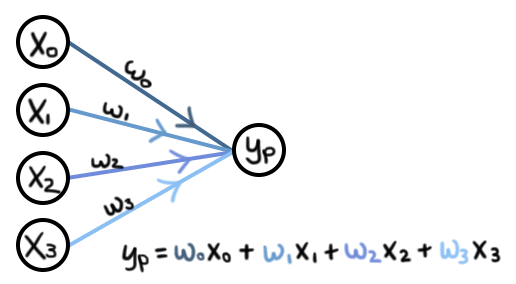

In [1]:
from IPython.display import Image
Image(filename='figs/linear_regression_as_neural_network2.png', width=500)
# Image is taken from https://blog.insightdatascience.com/a-quick-introduction-to-vanilla-neural-networks-b0998c6216a1

## Linear regression from scratch

We will learn the parameters $w_0$ and $\mathbf{w}_1$ of a line.

In [2]:
# Import plotting packages
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

# Import machine-learning packages
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch import nn, optim
from torch_lr_finder import LRFinder
import torch.nn.functional as F

# Set random seed for reproducibility 
np.random.seed(42)

### What is pytorch? (as defined at https://pytorch.org/) 

It’s a Python-based scientific computing package targeted at two sets of audiences:

- A replacement for NumPy to use the power of GPUs
- A deep learning research platform that provides flexibility and speed

### Chose the true parameters we want to learn.

In [3]:
w = torch.as_tensor([3.,2]); w

tensor([3., 2.])

### Create some data points x and y which lie on the line

In [4]:
n = 100
x = torch.ones(n,2) 
x[:,1].uniform_(-1.,1) # Underscore functions in pytorch means replace the value (update)
x[:5]

tensor([[ 1.0000, -0.6071],
        [ 1.0000,  0.8203],
        [ 1.0000, -0.6757],
        [ 1.0000, -0.9822],
        [ 1.0000,  0.2638]])

Tensor is a data structure which is a fundamental building block of PyTorch. Tensors are pretty much like numpy arrays, except that unlike numpy, tensors are designed to take advantage of parallel computation capabilities of a GPU
and more importantly for us - they can keep track of its gradients.

For further reading, see [here](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)
    

In [5]:
y = x@w + torch.rand(n) # @ is a matrix product (similar to matmul)

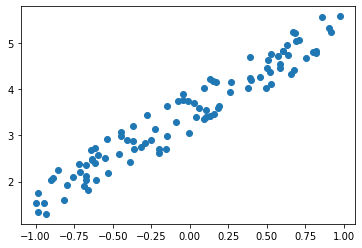

In [6]:
plt.scatter(x[:,1], y);

In [7]:
w_real = torch.as_tensor([-3.,-5])

If we could find a way to fit our guess for the coefficients the weights ($w_0$ and $\mathbf{w}_1$), we could use the exact same method for very complicated tasks (as in image recognition). 

In [8]:
def mse(y_true, y_pred): return ((y_true - y_pred)**2).mean()

Written in terms of $w_0$ and $w_1$, our **loss function** is:

### $L = \frac{1}{n}\sum_{i=1}^n [y_i - (w_0 + w_1 x_i)]^2$

In [9]:
y_hat = x@w_real
mse(y_hat, y) # Initial mean-squared error

tensor(54.0088)

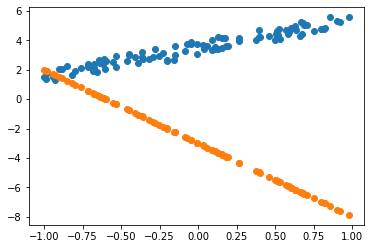

In [10]:
plt.scatter(x[:,1], y)
plt.scatter(x[:,1], y_hat);

In [11]:
w = nn.Parameter(w_real); w

Parameter containing:
tensor([-3., -5.], requires_grad=True)

#### So far, we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for weights ($w_0$, $w_1$)? How do we find the best *fitting* linear regression.

To know how to change $w_0$ and $w_1$ to reduce the loss, we compute the derivatives (or gradients).

$\frac{\partial L}{\partial w_0} = \frac{1}{n}\sum_i -2[y_i - (w_0 + w_1 x_i)]$

$\frac{\partial L}{\partial w_1} = \frac{1}{n}\sum_i -2[y_i - (w_0 + w_1 x_i)]x_i$

#### If we know those we can iteratively take little steps down the gradient to reduce the loss, aka, *gradient descent*. How big our steps are is determined by the *learning rate*.

$w_0^{new} = w_0^{old}$ - Learning-Rate $*  \frac{\partial L}{\partial w_0}$

$w_1^{new} = w_1^{old}$ - Learning-Rate $*  \frac{\partial L}{\partial w_1}$

In [12]:
def update2(iteration):
    y_hat = x@w
    loss = mse(y, y_hat)
    loss.backward(); #calculate the gradient of a tensor! It is now stored at w.grad
    
    # To prevent tracking history and using memory 
    # (code block where we don't need to track the gradients but only modify the values of tensors)
    with torch.no_grad(): 
        w.sub_(lr * w.grad); # Under score means inplace. 
        # lr is the learning rate. Good learning rate is a key part of Neural Networks. 
        
        w.grad.zero_()
        # We want to zero the gradient before we are re-evaluate it.

    return loss

In PyTorch, we need to set the gradients to zero before starting to do back propragation because PyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call.
Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Else the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

Explanations about how PyTorch calculates the gradients can be found here (and in many other sources) - https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/

In [13]:
def lin(w1, w0, x): return w1*x + w0

In [14]:
w = torch.as_tensor([-2.,-3])
w = nn.Parameter(w);
lr =0.001
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x[:,0], y)
line, = ax.plot(x[:,0], lin(w.detach().numpy()[0] , w.detach().numpy()[1] , x.detach().numpy()[:,0]), c='firebrick')
# line, = ax.plot(x[:,0], y, c='firebrick')
ax.set_title('Loss = 0.00')
plt.close()

def animate(i):
    for t in range(100): l = update2(t)
    ax.set_title('Loss = %.2f' % l);
    line.set_data(x.detach().numpy()[:,0], 
                  lin(w.detach().numpy()[0] , w.detach().numpy()[1] , x.detach().numpy()[:,0]));
    return line,

anim = FuncAnimation(fig, animate, frames=70, interval=150, blit=True);

In [15]:
# You might have some difficulties running this cell without importing certain packages. 
# might need to install: conda install -c conda-forge ffmpeg
HTML(anim.to_html5_video())

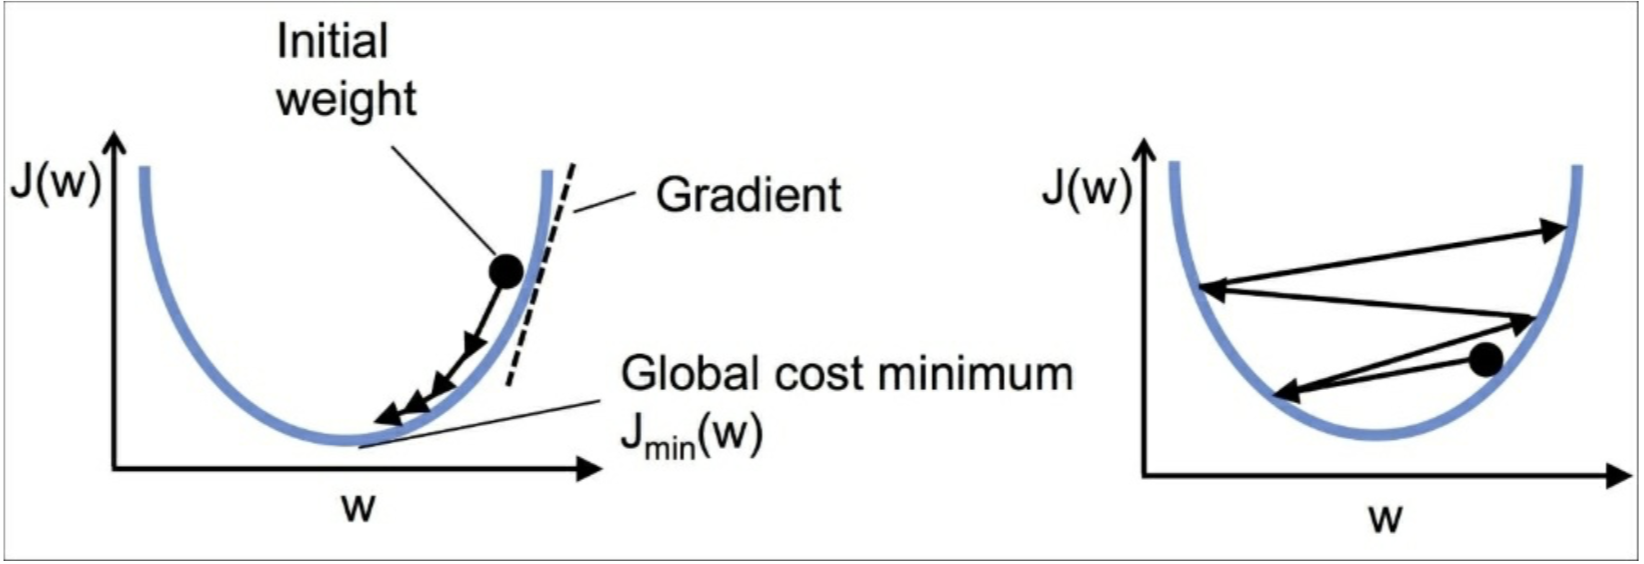

In [16]:
Image(filename='figs/Gradient_descent2.png', width=700)

Text(0, 0.5, 'Loss')

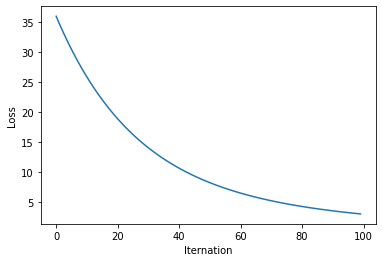

In [17]:
w = torch.as_tensor([-2.,-3])
w = nn.Parameter(w);
lr =0.01
losses = []
for t in range(100): 
    losses.append(update2(t).detach().numpy())
    
plt.plot(np.array(losses))
plt.xlabel('Iternation')
plt.ylabel('Loss')

#### In Deep learning, we use a variation of gradient descent called [mini-batch gradient descent](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/):
Instead of calculating the gradient over the whole training data before changing model weights (coefficients), we take a subset (batch) of our data, and change the values of the weights after we calculated the gradient over this subset. 